# SPY Price Prediction: SVR and HMM Models

This notebook implements two machine learning models for predicting next-day SPY prices:
1. Support Vector Regression (SVR)
2. Hidden Markov Model (HMM)

**Training Period**: Jan 1, 2015 - Dec 31, 2021

**Testing Period**: Jan 1, 2022 - June 1, 2025

**Evaluation Metric**: Mean Squared Error (MSE)

## 1. Setup and Data Loading

In [4]:
# Import required libraries
# Modern imports (recommended)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from hmmlearn import hmm

# Set display options
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Load the complete dataset
data_path = '../Data/spy_complete_dataset.csv'
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns: {len(df.columns)}")
df.head()

Dataset loaded: (2619, 239)
Date range: 2014-12-31 00:00:00 to 2025-05-30 00:00:00

Columns: 239


,Date,SPY_AdjClose,SPY_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,CPI,CorePCE,Payrolls,Unemployment,RetailSales,Yield10,Yield2,VIX,DurGoodsOrders,CoreCapexOrders,IndProd_Manufacturing,TermSpread,prev_Close,gap_abs,gap_pct,gap_log,overnight_ret,overnight_logret,...,ZScores_DGS10,ZScores_DGS5,ZScores_Spread,ZScores_DefCyc_Ratio,ZScores_Avg_Sector_Corr,ZScores_Crude_60dRet,ZScores_Copper_60dRet,VVIX,SKEW,VIX3M,UST_2Y,UST_10Y,SPREAD_10_2,HY_OAS,IG_OAS,HY_minus_IG,Risk_Appetite,FX_flow_vol_z20,FX_flow_money_proxy5,FX_uso_ret5,FX_gld_ret5,FX_eurusd_ret5,FX_usdjpy_ret5,FX_usd_strength,FX_breadth_proxy
0,2014-12-31,171.185333,205.539993,208.190002,205.389999,207.990005,130333800,NaN,NaN,NaN,NaN,NaN,2.17,0.67,19.20,NaN,NaN,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900,NaN,NaN,NaN,NaN,NaN,2.12,0.66,17.79,NaN,NaN,NaN,1.46,171.101663,0.749350,0.004380,0.004370,0.004380,0.004370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.550003,128.660004,19.459999,0.66,2.12,1.46,5.08,1.45,3.63,-3.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-05,168.003799,201.720001,204.369995,201.350006,204.169998,169632600,NaN,NaN,NaN,NaN,NaN,2.04,0.68,19.92,NaN,NaN,NaN,1.36,171.043380,-1.024112,-0.005987,-0.006005,-0.005987,-0.006005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.870003,127.790001,20.790001,0.68,2.04,1.36,5.21,1.46,3.75,-3.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-06,166.421356,199.820007,202.720001,198.860001,202.089996,209151400,NaN,NaN,NaN,NaN,NaN,1.97,0.65,21.12,NaN,NaN,NaN,1.32,167.987696,0.308066,0.001834,0.001832,0.001834,0.001832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.449997,125.269997,21.420000,0.65,1.97,1.32,5.37,1.48,3.89,-3.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-07,168.495193,202.309998,202.720001,200.880005,201.419998,125346700,NaN,NaN,NaN,NaN,NaN,1.96,0.62,19.31,NaN,NaN,NaN,1.34,166.372430,1.365483,0.008207,0.008174,0.008207,0.008174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.690002,123.559998,20.080000,0.62,1.96,1.34,5.31,1.49,3.82,-3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Preprocessing

In [6]:
# Create target variable: next day's adjusted close price
df['Target'] = df['SPY_AdjClose'].shift(-1)

# Remove the last row (no target available)
df = df[:-1].copy()

print(f"Target variable created: predicting next day's SPY_AdjClose")
print(f"Dataset shape after target creation: {df.shape}")

Target variable created: predicting next day's SPY_AdjClose
Dataset shape after target creation: (2618, 240)


In [7]:
# Split data into train and test sets based on date
train_end_date = '2021-12-31'
test_start_date = '2022-01-01'
test_end_date = '2025-06-01'

train_df = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= train_end_date)].copy()
test_df = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)].copy()

print(f"Training set: {train_df.shape} ({train_df['Date'].min()} to {train_df['Date'].max()})")
print(f"Testing set: {test_df.shape} ({test_df['Date'].min()} to {test_df['Date'].max()})")

Training set: (1763, 240) (2015-01-02 00:00:00 to 2021-12-31 00:00:00)
Testing set: (854, 240) (2022-01-03 00:00:00 to 2025-05-29 00:00:00)


In [8]:
# Select features for modeling
# Exclude: Date, Target, and columns with too many missing values
exclude_cols = ['Date', 'Target']

# Calculate missing percentage for each column
missing_pct = train_df.isnull().sum() / len(train_df) * 100
high_missing_cols = missing_pct[missing_pct > 20].index.tolist()

print(f"\nColumns with >20% missing values: {len(high_missing_cols)}")
print(high_missing_cols[:10])

# Get feature columns
all_exclude = exclude_cols + high_missing_cols
feature_cols = [col for col in train_df.columns if col not in all_exclude]

print(f"\nTotal features for modeling: {len(feature_cols)}")


Columns with >20% missing values: 24
['Prices_XLC', 'Returns_SPY', 'Returns_XLB', 'Returns_XLC', 'Returns_XLE', 'Returns_XLF', 'Returns_XLK', 'Returns_XLP', 'Returns_XLRE', 'Returns_XLU']

Total features for modeling: 214


In [9]:
# Handle missing values in remaining features
# Forward fill first, then backward fill, then fill with 0
X_train = train_df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
y_train = train_df['Target'].values

X_test = test_df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
y_test = test_df['Target'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

X_train shape: (1763, 214)
X_test shape: (854, 214)
y_train shape: (1763,)
y_test shape: (854,)

Missing values in X_train: 0
Missing values in X_test: 0


C:\Users\iris6\AppData\Local\Temp\ipykernel_37636\883420163.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = train_df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\iris6\AppData\Local\Temp\ipykernel_37636\883420163.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = test_df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)


In [10]:
# Feature scaling (important for SVR)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Features scaled successfully!")
print(f"X_train_scaled mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"X_test_scaled mean: {X_test_scaled.mean():.6f}, std: {X_test_scaled.std():.6f}")

Features scaled successfully!
X_train_scaled mean: -0.000000, std: 1.000000
X_test_scaled mean: 0.578935, std: 1.609369


## 3. Support Vector Regression (SVR)

In [11]:
print("="*80)
print("Training Support Vector Regression Model")
print("="*80)

# Initialize SVR with RBF kernel
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1, cache_size=1000)

# Train the model
print("\nTraining SVR model...")
svr_model.fit(X_train_scaled, y_train)
print("SVR model trained successfully!")

# Make predictions
print("\nMaking predictions...")
svr_train_pred = svr_model.predict(X_train_scaled)
svr_test_pred = svr_model.predict(X_test_scaled)
print("Predictions completed!")

Training Support Vector Regression Model

Training SVR model...
SVR model trained successfully!

Making predictions...
Predictions completed!


In [12]:
# Evaluate SVR model
svr_train_mse = mean_squared_error(y_train, svr_train_pred)
svr_train_rmse = np.sqrt(svr_train_mse)
svr_train_mae = mean_absolute_error(y_train, svr_train_pred)
svr_train_r2 = r2_score(y_train, svr_train_pred)

svr_test_mse = mean_squared_error(y_test, svr_test_pred)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_mae = mean_absolute_error(y_test, svr_test_pred)
svr_test_r2 = r2_score(y_test, svr_test_pred)

print("\n" + "="*80)
print("SVR Model Performance")
print("="*80)
print("\nTraining Set:")
print(f"  MSE:  {svr_train_mse:.4f}")
print(f"  RMSE: {svr_train_rmse:.4f}")
print(f"  MAE:  {svr_train_mae:.4f}")
print(f"  R²:   {svr_train_r2:.4f}")

print("\nTesting Set:")
print(f"  MSE:  {svr_test_mse:.4f}")
print(f"  RMSE: {svr_test_rmse:.4f}")
print(f"  MAE:  {svr_test_mae:.4f}")
print(f"  R²:   {svr_test_r2:.4f}")
print("="*80)


SVR Model Performance

Training Set:
  MSE:  0.6539
  RMSE: 0.8086
  MAE:  0.2520
  R²:   0.9999

Testing Set:
  MSE:  31749.4772
  RMSE: 178.1838
  MAE:  156.6149
  R²:   -4.3451


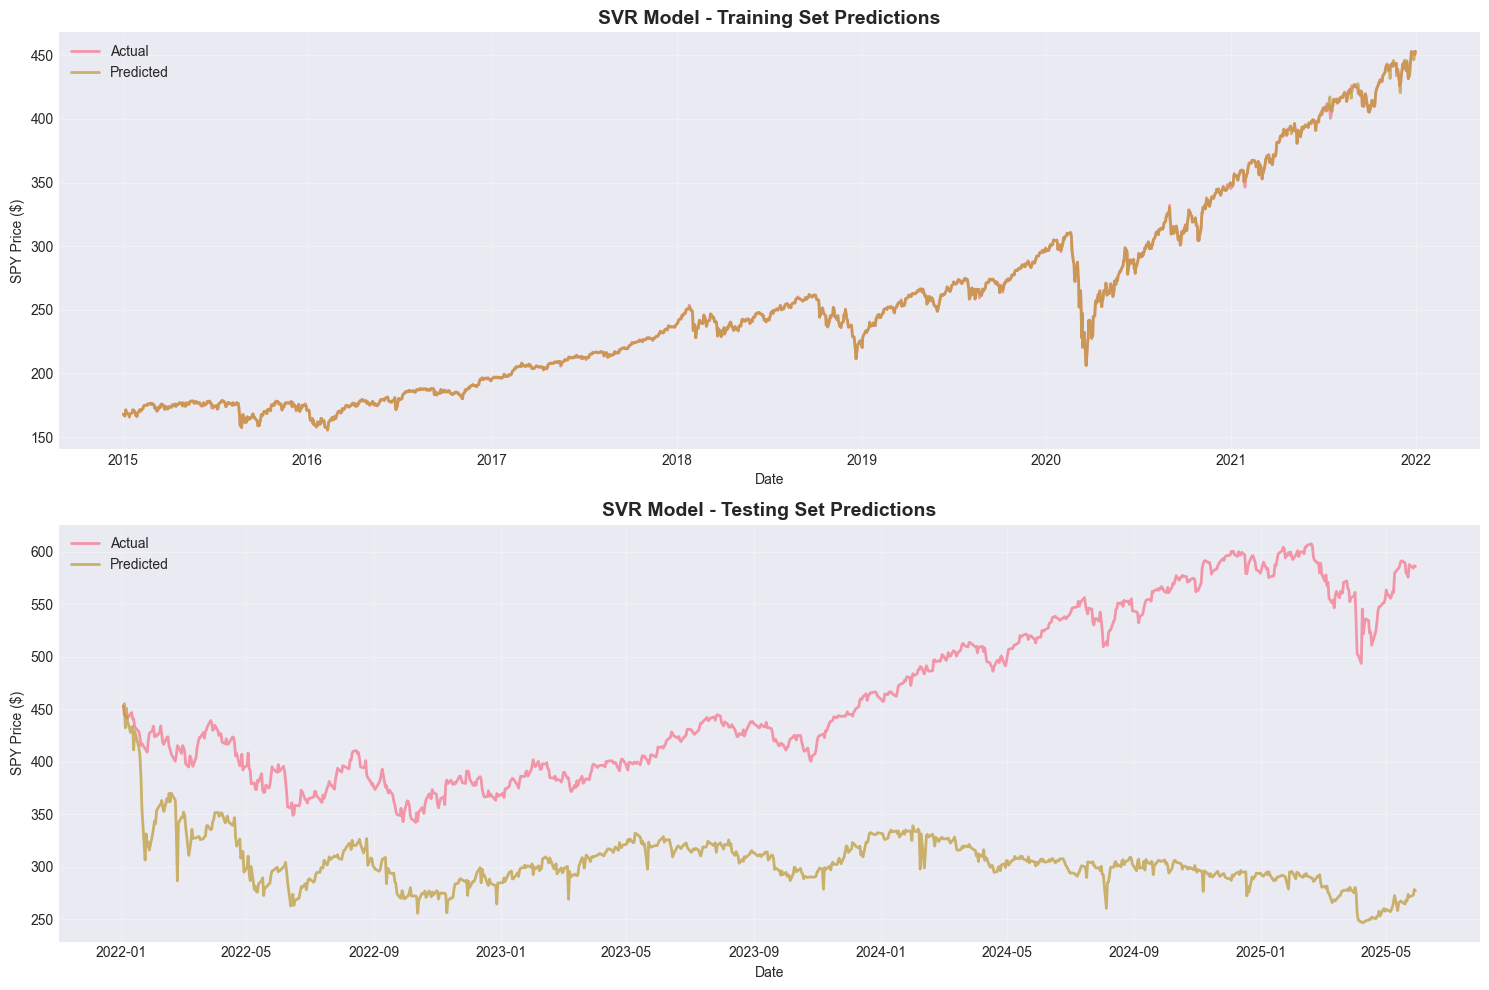

SVR prediction plots saved!


In [13]:
# Visualize SVR predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Training set
axes[0].plot(train_df['Date'].values, y_train, label='Actual', alpha=0.7, linewidth=2)
axes[0].plot(train_df['Date'].values, svr_train_pred, label='Predicted', alpha=0.7, linewidth=2)
axes[0].set_title('SVR Model - Training Set Predictions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('SPY Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].plot(test_df['Date'].values, y_test, label='Actual', alpha=0.7, linewidth=2)
axes[1].plot(test_df['Date'].values, svr_test_pred, label='Predicted', alpha=0.7, linewidth=2)
axes[1].set_title('SVR Model - Testing Set Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('SPY Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Data/svr_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("SVR prediction plots saved!")

## 4. Hidden Markov Model (HMM)

For HMM-based regression, we'll use a Gaussian HMM to model different market regimes and predict prices.

In [14]:
print("="*80)
print("Training Hidden Markov Model")
print("="*80)

# Prepare data for HMM
# HMM works better with sequential data, so we'll use returns and key features
hmm_features = [
    'ret_1d', 'logret_1d', 'roll_ret_5d', 'roll_ret_10d', 'roll_ret_20d',
    'RSI_14', 'MACD_hist', 'ATR_14', 
    'RealizedVol_20d_ann', 'SPY_Volume'
]

# Check which features are available
available_hmm_features = [f for f in hmm_features if f in feature_cols]
print(f"\nUsing {len(available_hmm_features)} features for HMM: {available_hmm_features}")

# Prepare HMM training data
X_hmm_train = X_train[available_hmm_features].values
X_hmm_test = X_test[available_hmm_features].values

# Scale HMM features
scaler_hmm = StandardScaler()
X_hmm_train_scaled = scaler_hmm.fit_transform(X_hmm_train)
X_hmm_test_scaled = scaler_hmm.transform(X_hmm_test)

print(f"\nHMM training data shape: {X_hmm_train_scaled.shape}")
print(f"HMM testing data shape: {X_hmm_test_scaled.shape}")

Training Hidden Markov Model

Using 10 features for HMM: ['ret_1d', 'logret_1d', 'roll_ret_5d', 'roll_ret_10d', 'roll_ret_20d', 'RSI_14', 'MACD_hist', 'ATR_14', 'RealizedVol_20d_ann', 'SPY_Volume']

HMM training data shape: (1763, 10)
HMM testing data shape: (854, 10)


In [15]:
# Train Gaussian HMM with multiple states (representing market regimes)
n_components = 3  # Number of hidden states (e.g., bullish, bearish, sideways)

print(f"\nTraining Gaussian HMM with {n_components} hidden states...")
hmm_model = hmm.GaussianHMM(
    n_components=n_components,
    covariance_type='diag',
    n_iter=100,
    random_state=42
)

# Fit the HMM model
hmm_model.fit(X_hmm_train_scaled)
print("HMM model trained successfully!")

# Predict hidden states
train_states = hmm_model.predict(X_hmm_train_scaled)
test_states = hmm_model.predict(X_hmm_test_scaled)

print(f"\nHidden states distribution (training):")
print(pd.Series(train_states).value_counts().sort_index())
print(f"\nHidden states distribution (testing):")
print(pd.Series(test_states).value_counts().sort_index())


Training Gaussian HMM with 3 hidden states...
HMM model trained successfully!

Hidden states distribution (training):
0    531
1    715
2    517
Name: count, dtype: int64

Hidden states distribution (testing):
1    308
2    546
Name: count, dtype: int64


In [16]:
# HMM-based prediction approach:
# For each state, calculate the mean price, then use state prediction to estimate next price

# Calculate mean prices for each state in training set
state_prices = {}
for state in range(n_components):
    state_mask = train_states == state
    state_prices[state] = y_train[state_mask].mean()

print("\nMean prices by hidden state (training):")
for state, price in state_prices.items():
    print(f"  State {state}: ${price:.2f}")

# Improved HMM prediction: use state-based price adjustment
# Instead of just mean price, use previous price + state-based return
state_returns = {}
for state in range(n_components):
    state_mask = train_states == state
    if state_mask.sum() > 0:
        state_returns[state] = (y_train[state_mask] / train_df.loc[train_df.index[state_mask], 'SPY_AdjClose'].values).mean()
    else:
        state_returns[state] = 1.0

print("\nPrice multipliers by hidden state:")
for state, mult in state_returns.items():
    print(f"  State {state}: {mult:.6f}")


Mean prices by hidden state (training):
  State 0: $207.19
  State 1: $283.16
  State 2: $261.08

Price multipliers by hidden state:
  State 0: 0.999992
  State 1: 1.001095
  State 2: 1.000590


In [17]:
# Make HMM predictions
# Use current price * state-based multiplier for better predictions
current_train_prices = train_df['SPY_AdjClose'].values
current_test_prices = test_df['SPY_AdjClose'].values

hmm_train_pred = np.array([current_train_prices[i] * state_returns[train_states[i]] 
                           for i in range(len(train_states))])
hmm_test_pred = np.array([current_test_prices[i] * state_returns[test_states[i]] 
                          for i in range(len(test_states))])

print("\nHMM predictions completed!")
print(f"Train predictions - min: ${hmm_train_pred.min():.2f}, max: ${hmm_train_pred.max():.2f}")
print(f"Test predictions - min: ${hmm_test_pred.min():.2f}, max: ${hmm_test_pred.max():.2f}")


HMM predictions completed!
Train predictions - min: $155.53, max: $453.49
Test predictions - min: $342.39, max: $608.27


In [18]:
# Evaluate HMM model
hmm_train_mse = mean_squared_error(y_train, hmm_train_pred)
hmm_train_rmse = np.sqrt(hmm_train_mse)
hmm_train_mae = mean_absolute_error(y_train, hmm_train_pred)
hmm_train_r2 = r2_score(y_train, hmm_train_pred)

hmm_test_mse = mean_squared_error(y_test, hmm_test_pred)
hmm_test_rmse = np.sqrt(hmm_test_mse)
hmm_test_mae = mean_absolute_error(y_test, hmm_test_pred)
hmm_test_r2 = r2_score(y_test, hmm_test_pred)

print("\n" + "="*80)
print("HMM Model Performance")
print("="*80)
print("\nTraining Set:")
print(f"  MSE:  {hmm_train_mse:.4f}")
print(f"  RMSE: {hmm_train_rmse:.4f}")
print(f"  MAE:  {hmm_train_mae:.4f}")
print(f"  R²:   {hmm_train_r2:.4f}")

print("\nTesting Set:")
print(f"  MSE:  {hmm_test_mse:.4f}")
print(f"  RMSE: {hmm_test_rmse:.4f}")
print(f"  MAE:  {hmm_test_mae:.4f}")
print(f"  R²:   {hmm_test_r2:.4f}")
print("="*80)


HMM Model Performance

Training Set:
  MSE:  8.1149
  RMSE: 2.8487
  MAE:  1.7515
  R²:   0.9986

Testing Set:
  MSE:  29.1410
  RMSE: 5.3982
  MAE:  3.7626
  R²:   0.9951


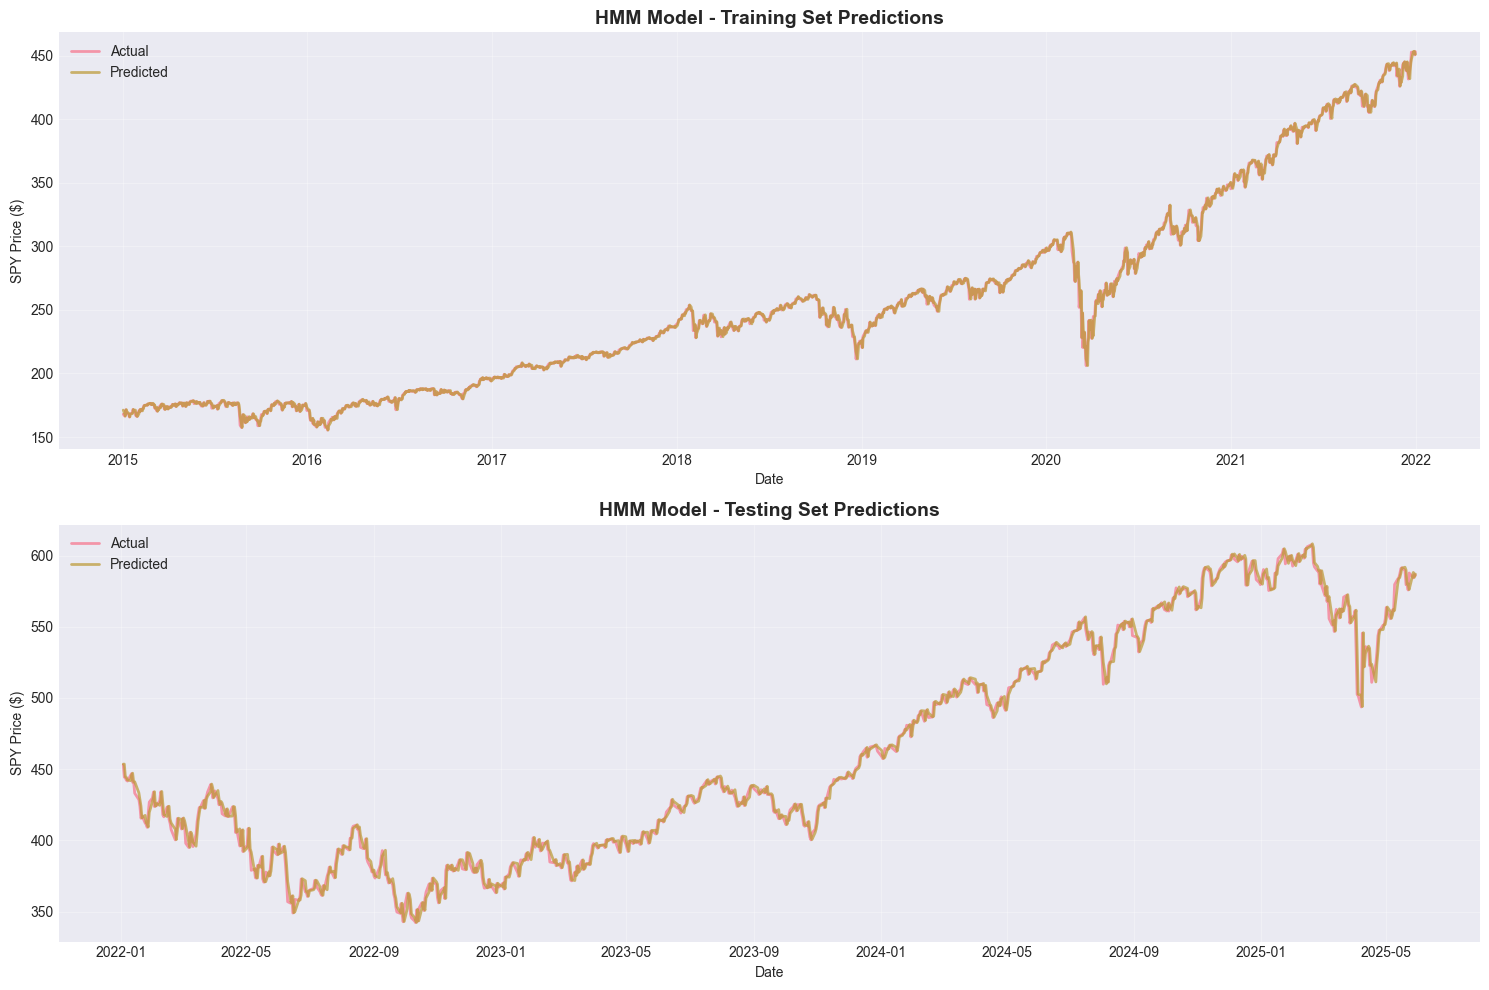

HMM prediction plots saved!


In [19]:
# Visualize HMM predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Training set
axes[0].plot(train_df['Date'].values, y_train, label='Actual', alpha=0.7, linewidth=2)
axes[0].plot(train_df['Date'].values, hmm_train_pred, label='Predicted', alpha=0.7, linewidth=2)
axes[0].set_title('HMM Model - Training Set Predictions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('SPY Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].plot(test_df['Date'].values, y_test, label='Actual', alpha=0.7, linewidth=2)
axes[1].plot(test_df['Date'].values, hmm_test_pred, label='Predicted', alpha=0.7, linewidth=2)
axes[1].set_title('HMM Model - Testing Set Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('SPY Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Data/hmm_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("HMM prediction plots saved!")

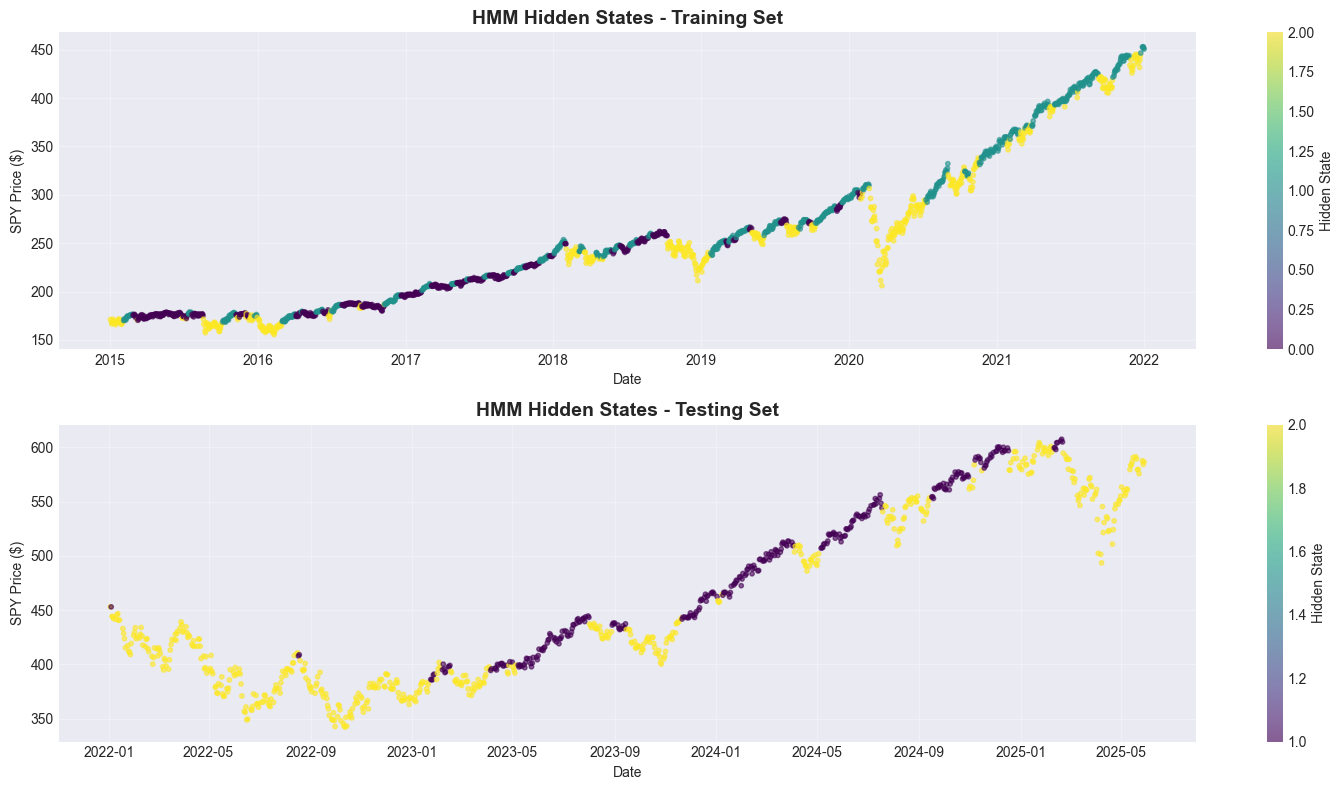

HMM states visualization saved!


In [20]:
# Visualize hidden states over time
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Training set
axes[0].scatter(train_df['Date'].values, train_df['SPY_AdjClose'].values, 
                c=train_states, cmap='viridis', alpha=0.6, s=10)
axes[0].set_title('HMM Hidden States - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('SPY Price ($)')
axes[0].grid(True, alpha=0.3)
cbar0 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar0.set_label('Hidden State')

# Testing set
axes[1].scatter(test_df['Date'].values, test_df['SPY_AdjClose'].values, 
                c=test_states, cmap='viridis', alpha=0.6, s=10)
axes[1].set_title('HMM Hidden States - Testing Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('SPY Price ($)')
axes[1].grid(True, alpha=0.3)
cbar1 = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar1.set_label('Hidden State')

plt.tight_layout()
plt.savefig('../Data/hmm_states.png', dpi=150, bbox_inches='tight')
plt.show()

print("HMM states visualization saved!")

## 5. Model Comparison and Final Results

In [21]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['SVR', 'HMM'],
    'Train_MSE': [svr_train_mse, hmm_train_mse],
    'Train_RMSE': [svr_train_rmse, hmm_train_rmse],
    'Train_MAE': [svr_train_mae, hmm_train_mae],
    'Train_R2': [svr_train_r2, hmm_train_r2],
    'Test_MSE': [svr_test_mse, hmm_test_mse],
    'Test_RMSE': [svr_test_rmse, hmm_test_rmse],
    'Test_MAE': [svr_test_mae, hmm_test_mae],
    'Test_R2': [svr_test_r2, hmm_test_r2]
})

print("\n" + "="*80)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*80)
print("\n", results_df.to_string(index=False))
print("\n" + "="*80)

# Determine best model based on Test MSE
best_model_idx = results_df['Test_MSE'].idxmin()
best_model = results_df.loc[best_model_idx, 'Model']
best_mse = results_df.loc[best_model_idx, 'Test_MSE']

print(f"\nBEST MODEL (by Test MSE): {best_model}")
print(f"Test MSE: {best_mse:.4f}")
print("="*80)


MODEL COMPARISON - FINAL RESULTS

 Model  Train_MSE  Train_RMSE  Train_MAE  Train_R2     Test_MSE  Test_RMSE   Test_MAE   Test_R2
  SVR   0.653873    0.808624   0.252039  0.999885 31749.477231 178.183830 156.614930 -4.345083
  HMM   8.114934    2.848672   1.751492  0.998578    29.141050   5.398245   3.762566  0.995094


BEST MODEL (by Test MSE): HMM
Test MSE: 29.1410


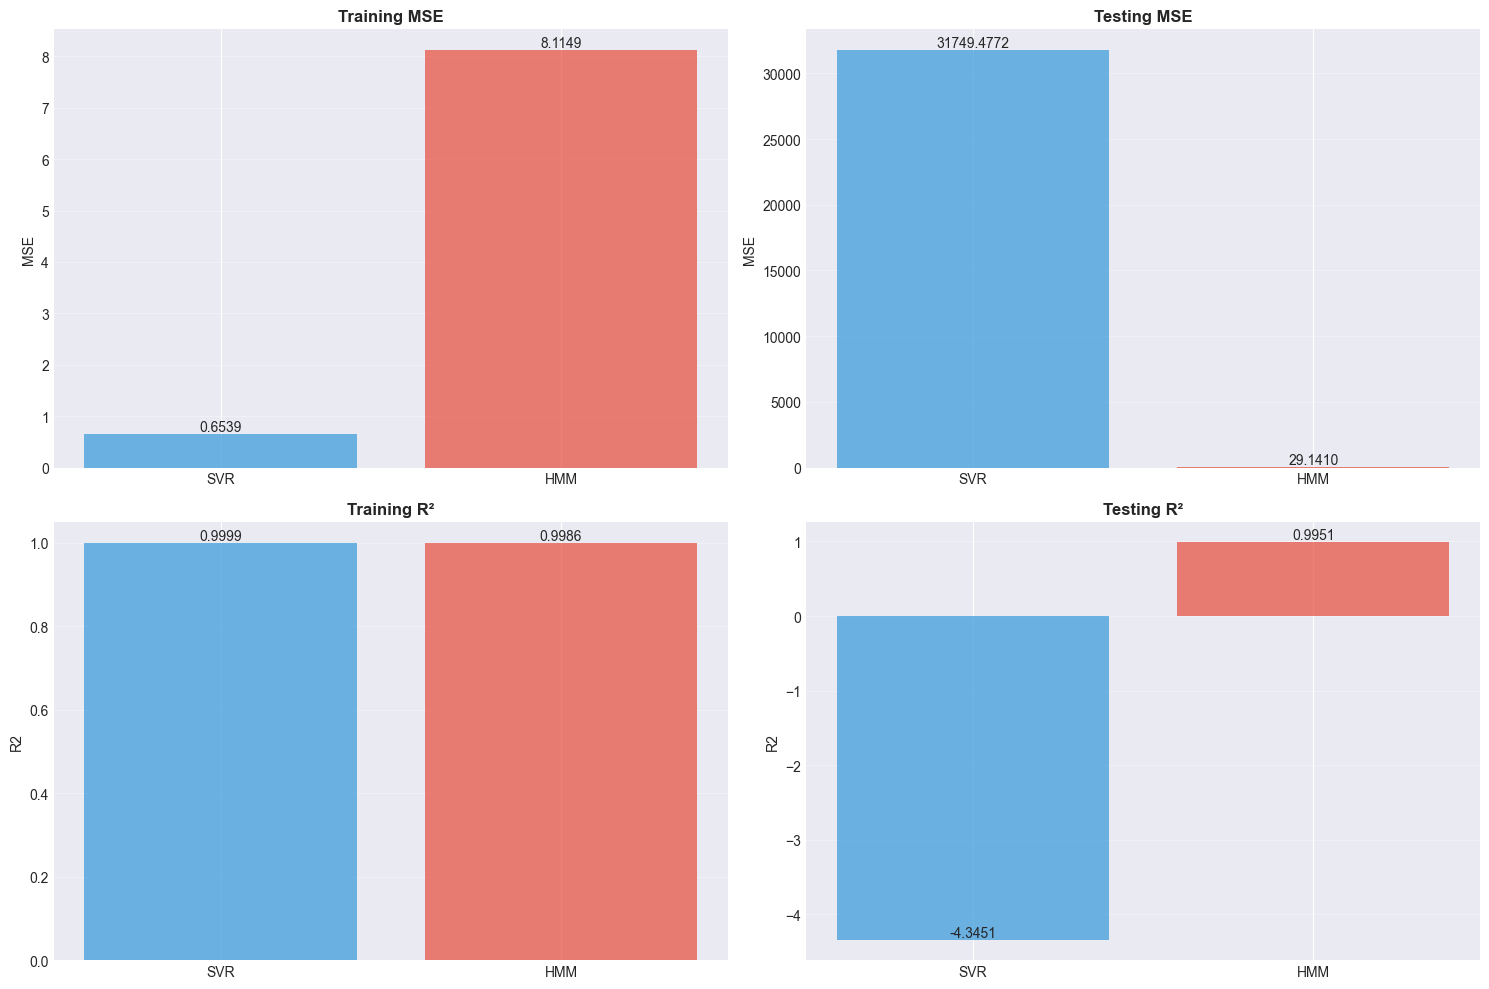

Model comparison visualization saved!


In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Train_MSE', 'Test_MSE', 'Train_R2', 'Test_R2']
titles = ['Training MSE', 'Testing MSE', 'Training R²', 'Testing R²']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    bars = ax.bar(results_df['Model'], results_df[metric], color=['#3498db', '#e74c3c'], alpha=0.7)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.split('_')[-1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../Data/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved!")

In [23]:
# Save results to CSV
results_df.to_csv('../Data/model_comparison_results.csv', index=False)
print("\nResults saved to: ../Data/model_comparison_results.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Date': test_df['Date'].values,
    'Actual': y_test,
    'SVR_Prediction': svr_test_pred,
    'HMM_Prediction': hmm_test_pred,
    'SVR_Error': y_test - svr_test_pred,
    'HMM_Error': y_test - hmm_test_pred
})

predictions_df.to_csv('../Data/test_predictions.csv', index=False)
print("Predictions saved to: ../Data/test_predictions.csv")


Results saved to: ../Data/model_comparison_results.csv
Predictions saved to: ../Data/test_predictions.csv


In [24]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDataset Information:")
print(f"  Total features: {len(feature_cols)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")

print(f"\nActual Price Statistics (Test Set):")
print(f"  Mean: ${y_test.mean():.2f}")
print(f"  Std:  ${y_test.std():.2f}")
print(f"  Min:  ${y_test.min():.2f}")
print(f"  Max:  ${y_test.max():.2f}")

print(f"\nPrediction Errors (Test Set):")
print(f"  SVR Mean Error: ${(y_test - svr_test_pred).mean():.2f}")
print(f"  HMM Mean Error: ${(y_test - hmm_test_pred).mean():.2f}")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


SUMMARY STATISTICS

Dataset Information:
  Total features: 214
  Training samples: 1763
  Testing samples: 854

Actual Price Statistics (Test Set):
  Mean: $460.98
  Std:  $77.07
  Min:  $342.19
  Max:  $607.61

Prediction Errors (Test Set):
  SVR Mean Error: $156.57
  HMM Mean Error: $-0.21

Analysis Complete!
